In [1]:
from collections import OrderedDict
from seqdataloader.batchproducers import coordbased
from seqdataloader.batchproducers.coordbased import coordstovals
from seqdataloader.batchproducers.coordbased import coordbatchproducers
from seqdataloader.batchproducers.coordbased import coordbatchtransformers
from seqdataloader.batchproducers.coordbased.core import Coordinates
from seqdataloader.batchproducers.coordbased.coordstovals.core import CoordsToValsJoiner
from seqdataloader.batchproducers.coordbased.coordstovals.bigwig import AbstractCountAndProfileTransformer 
from seqdataloader.batchproducers.coordbased.coordstovals.bigwig import LogCountsPlusOne
from seqdataloader.batchproducers.coordbased.coordstovals.bigwig import SmoothProfiles
from seqdataloader.batchproducers.coordbased.coordstovals.bigwig import BigWigReader 
from seqdataloader.batchproducers.coordbased.coordstovals.bigwig import smooth_profiles
from seqdataloader.batchproducers.coordbased.coordstovals.bigwig import rolling_window
from seqdataloader.batchproducers.coordbased.coordstovals.bigwig import MultiTrackCountsAndProfile
import keras
import keras.layers as kl
import tensorflow as tf
import numpy as np
from keras_genomics.layers.convolutional import RevCompConv1D
from seqdataloader.batchproducers.coordbased.core import Coordinates, KerasBatchGenerator, apply_mask
from keras.models import load_model
import os
from keras.utils import CustomObjectScope
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"

Using TensorFlow backend.
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/users/amr1/mi

In [2]:
#Written by Žiga Avsec
import pyBigWig
#loss function
def multinomial_nll(true_counts, logits):
    """Compute the multinomial negative log-likelihood
    Args:
      true_counts: observed count values
      logits: predicted logit values
    """
    counts_per_example = tf.reduce_sum(true_counts, axis=-1)
    dist = tf.distributions.Multinomial(total_count=counts_per_example,
                                         logits=logits)
    return (-tf.reduce_sum(dist.log_prob(true_counts)) / 
            tf.to_float(tf.shape(true_counts)[0]))

#Written by Žiga Avsec
class MultichannelMultinomialNLL(object):
    def __init__(self, n):
        self.__name__ = "MultichannelMultinomialNLL"
        self.n = n

    def __call__(self, true_counts, logits):
        for i in range(self.n):
            loss = multinomial_nll(true_counts[..., i], logits[..., i])
            if i == 0:
                total = loss
            else:
                total += loss
        return total

    def get_config(self):
        return {"n": self.n}
def get_new_coors_around_center(coors, center_size_to_use):
    new_coors = []
    for coor in coors:
        coor_center = int(0.5*(coor.start + coor.end))
        left_flank = int(0.5*center_size_to_use)
        right_flank = center_size_to_use - left_flank
        new_start = coor_center-left_flank
        new_end = coor_center+right_flank
        new_coors.append(Coordinates(chrom=coor.chrom,
                                     start=new_start, end=new_end,
                                     isplusstrand=coor.isplusstrand))
    return new_coors

task_names = ["pho4", "cbf1"]

# If we want to avoid zero-padding, then the size of the output predictions
# will depend on the size of the input sequence supplied. We define the
# API for an AbstractProfileModel class which returns the length of the
# output profile in addition to returning the model, given information
# on the size of the input sequence and the model parameters.
        
class AbstractProfileModel(object):
    
    def get_output_profile_len(self):
        raise NotImplementedError()
  
    def get_model(self):
        raise NotImplementedError()
  
# The architecture by Žiga Avsec involves residual connections, which means
# that the layers being added together in an elementwise fashion need
# to have the same dimensions. To achieve this without zero-padding, we
# have to trim away the flanks of earlier convolutional layers. That
# is what this function is meant to do. (Note that the original BP-net
# architecture zero-pads; this is a modification to avoid the zero
# padding and use information on actual sequence instead)

def trim_flanks_of_conv_layer(conv_layer, output_len, width_to_trim, filters):
    layer = keras.layers.Lambda(
        lambda x: x[:,
          int(0.5*(width_to_trim)):-(width_to_trim-int(0.5*(width_to_trim)))],
        output_shape=(output_len, filters))(conv_layer)
    return layer
        
#This model architecture is based on BP-Net by Žiga Avsec
# https://drive.google.com/file/d/1kg6Ic0-FvJtVUva9Mh3FPnOAHJcN6VB-/view
#It has been modified for this specific use-case.

class RcBPnetArch(AbstractProfileModel):   

    def __init__(self, input_seq_len, c_task_weight, filters,
                       n_dil_layers, conv1_kernel_size,
                       dil_kernel_size,
                       outconv_kernel_size, lr):
        self.input_seq_len = input_seq_len
        self.c_task_weight = c_task_weight
        self.filters = filters
        self.n_dil_layers = n_dil_layers
        self.conv1_kernel_size = conv1_kernel_size
        self.dil_kernel_size = dil_kernel_size
        self.outconv_kernel_size = outconv_kernel_size
        self.lr = lr

    def get_embedding_len(self):
        embedding_len = self.input_seq_len
        embedding_len -= (self.conv1_kernel_size-1)     
        for i in range(1, self.n_dil_layers+1):
            dilation_rate = (2**i)
            embedding_len -= dilation_rate*(self.dil_kernel_size-1)
        return embedding_len

    def get_output_profile_len(self):
        embedding_len = self.get_embedding_len()
        out_profile_len = embedding_len - (self.outconv_kernel_size - 1)
        return out_profile_len
    
    def get_keras_model(self):
      
        out_pred_len = self.get_output_profile_len()

        inp = kl.Input(shape=(self.input_seq_len, 4), name='sequence')
        first_conv = RevCompConv1D(filters=self.filters,
                               kernel_size=self.conv1_kernel_size,
                               padding='valid',
                               activation='relu')(inp)
        curr_layer_size = self.input_seq_len - (self.conv1_kernel_size-1)
        control_standard_counts_input = kl.Input(
            shape=(1,), name="control_logcount")
        control_standard_profile_input = kl.Input(
            shape=(out_pred_len, 2), name="control_profile")

        #Gather together all the tensors representing the model inputs
        model_inputs = [
            inp,
            control_standard_counts_input,
            control_standard_profile_input,
        ]
        
        #Prepare the stack of dilated convolutions with residual connections
        prev_layers = [first_conv]
        for i in range(1, self.n_dil_layers + 1):
            dilation_rate = 2**i
            if i == 1:
                prev_sum = first_conv
            else:
                prev_sum = kl.merge.Average()(prev_layers)
            conv_output = RevCompConv1D(filters=self.filters,
                                  kernel_size=self.dil_kernel_size,
                                  padding='valid',
                                  activation='relu',
                                  dilation_rate=dilation_rate)(prev_sum)          
            width_to_trim = dilation_rate*(self.dil_kernel_size-1)
            curr_layer_size = (curr_layer_size - width_to_trim)
            prev_layers = [trim_flanks_of_conv_layer(
                conv_layer=x, output_len=curr_layer_size,
                width_to_trim=width_to_trim, filters=2*self.filters) for x in prev_layers]
            prev_layers.append(conv_output)

        combined_conv = kl.merge.Average()(prev_layers)

        #gap = GlobalAveragePooling. This layer is used as input for the
        # counts prediction tasks.
        gap_combined_conv = kl.GlobalAvgPool1D()(combined_conv)
        
        lossarr = []
        lossweightsarr = []
        model_outputs = []

        #Define the output layers for the counts prediction tasks
        for countouttaskname, numunits, countcontrolinp in [
            ("pho4.logcount", 2, control_standard_counts_input),
            ("cbf1.logcount", 2, control_standard_counts_input)
        ]:
            count_out = kl.Reshape((-1,), name=countouttaskname)(
                RevCompConv1D(filters=1, kernel_size=1)(
                    kl.Reshape((1,-1))(kl.concatenate([
                        kl.Lambda(lambda x: x[:, ::-1])(countcontrolinp),
                        gap_combined_conv,countcontrolinp], axis=-1))))
            model_outputs.append(count_out)
            lossarr.append('mse')
            lossweightsarr.append(self.c_task_weight)

        #Define the output layers for the profile prediction tasks
        for profileouttaskname, numunits, profilecontrolinp in [
            ("pho4.profile", 2, control_standard_profile_input),
            ("cbf1.profile", 2, control_standard_profile_input)
        ]:     
            profile_out_precontrol = RevCompConv1D(
                                 filters=numunits,
                                 kernel_size=self.outconv_kernel_size,
                                 padding='valid')(combined_conv)
            profile_out = RevCompConv1D(
              filters=1, kernel_size=1, name=profileouttaskname)(
                kl.concatenate([
                    kl.Lambda(lambda x: x[:, :, ::-1])(profilecontrolinp),
                    profile_out_precontrol,profilecontrolinp], axis=-1))
            model_outputs.append(profile_out)
            lossarr.append(MultichannelMultinomialNLL(numunits)) 
            #We downweight the loss by the number of channels because, if you
            # read the code for MultichannelMultinomialNLL, you'll see that
            # the loss for different channels is added together;
            # but I (Avanti Shrikumar) didn't want to implicitly upweight
            # the prediction tasks that happen
            # to have more channels, hence this downweighting.
            lossweightsarr.append(1.0/numunits)

        #Compile the model and return it
        model = keras.models.Model(inputs=model_inputs, outputs=model_outputs)
        model.compile(keras.optimizers.Adam(lr=self.lr),
                      loss=lossarr,
                      loss_weights=lossweightsarr)
        return model

In [3]:
seq_len = 546 # remember to update

modelwrapper = RcBPnetArch(
    input_seq_len=seq_len, c_task_weight=100,
    filters=64,
    n_dil_layers=6,
    conv1_kernel_size=21,
    dil_kernel_size=3,
    outconv_kernel_size=75,
    lr=0.001)
out_pred_len = modelwrapper.get_output_profile_len()
print(out_pred_len, seq_len-out_pred_len)

200 346


In [4]:
# the code below is used to prepare instances of keras.utils.Sequence that
# can be supplied to model.fit_generator(...)
# Note that we log-transform our counts using np.log(counts+1)
# Also note that the profiles for the control are smoothed by windows of
# size 1 and 50 (smoothing by a window of size 1 just returns
# the original profile)

pos_neg_smooth_log_counts =\
  coordstovals.bigwig.PosAndNegSmoothWindowCollapsedLogCounts(
        pos_strand_bigwig_path="/users/amr1/pho4/data/ctl_pbexo/pbexo.pos_strand.bw",
        neg_strand_bigwig_path="/users/amr1/pho4/data/ctl_pbexo/pbexo.neg_strand.bw",
        counts_mode_name="control_logcount",
        profile_mode_name="control_profile",
        center_size_to_use=out_pred_len,
        smoothing_windows=[1,50])

inputs_coordstovals = coordstovals.core.CoordsToValsJoiner(
    coordstovals_list=[
      coordbased.coordstovals.fasta.PyfaidxCoordsToVals(
        genome_fasta_path="/users/amr1/pho4/data/genome/sacCer3.genome.fa",
        mode_name="sequence",
        center_size_to_use=seq_len),
      pos_neg_smooth_log_counts])

targets_coordstovals = coordstovals.core.CoordsToValsJoiner(
    coordstovals_list=[
      coordstovals.bigwig.PosAndNegSeparateLogCounts(
        counts_mode_name=task+".logcount",
        profile_mode_name=task+".profile",
        pos_strand_bigwig_path="/users/amr1/pho4/data/"+task+"_pbexo/basename_prefix.pooled.positive.bigwig",
        neg_strand_bigwig_path="/users/amr1/pho4/data/"+task+"_pbexo/basename_prefix.pooled.negative.bigwig",
        center_size_to_use=out_pred_len) for task in task_names])

keras_train_batch_generator = KerasBatchGenerator(
  coordsbatch_producer=coordbatchproducers.SimpleCoordsBatchProducer(
      bed_file="/users/amr1/pho4/data/multitask_pbexo/train_1000_around_summits.bed.gz",
      coord_batch_transformer=
          coordbatchtransformers.ReverseComplementAugmenter().chain(
          coordbatchtransformers.UniformJitter(
              maxshift=200, chromsizes_file="/users/amr1/pho4/data/genome/sacCer3.chrom.sizes")),
      batch_size=64,
      shuffle_before_epoch=True, 
      seed=1234),
  inputs_coordstovals=inputs_coordstovals,
  targets_coordstovals=targets_coordstovals)

keras_valid_batch_generator = KerasBatchGenerator(
  coordsbatch_producer=coordbatchproducers.SimpleCoordsBatchProducer(
            bed_file="/users/amr1/pho4/data/multitask_pbexo/valid_1000_around_summits.bed.gz",
            batch_size=64,
            shuffle_before_epoch=False, 
            seed=1234),
  inputs_coordstovals=inputs_coordstovals,
  targets_coordstovals=targets_coordstovals
)

#As a sanity check, print out the dimensions of everything in individual batches
sampinputs,samptargets = keras_train_batch_generator[0]
for key in sampinputs:
    print(key, sampinputs[key].shape)
for key in samptargets:
    print(key, samptargets[key].shape)

Heads up: coordinates in bed file are assumed to be on the positive strand; if strand in the bed file is improtant to you, please add that feature to SimpleCoordsBatchProducer
Heads up: coordinates in bed file are assumed to be on the positive strand; if strand in the bed file is improtant to you, please add that feature to SimpleCoordsBatchProducer
sequence (128, 546, 4)
control_logcount (128,)
control_profile (128, 200, 2)
pho4.logcount (128, 2)
pho4.profile (128, 200, 2)
cbf1.logcount (128, 2)
cbf1.profile (128, 200, 2)


In [5]:
model = modelwrapper.get_keras_model()
print(model.summary())

early_stopping_callback = keras.callbacks.EarlyStopping(
                            patience=10, restore_best_weights=True)

loss_history = model.fit_generator(keras_train_batch_generator,
                    epochs=200,
                    validation_data=keras_valid_batch_generator,
                    callbacks=[early_stopping_callback])

model.set_weights(early_stopping_callback.best_weights)
model_name = "/users/amr1/pho4/data/models/multitask_model.h5" 
model.save(model_name)





Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
Use `tf.cast` instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence (InputLayer)           (None, 546, 4)       0                                            
__________________________________________________________________________________________________
rev_comp_conv1d_1 (RevCompConv1 (None, 526, 128)     5440        sequence[0][0

evaluation

In [6]:
keras_test_batch_generator = coordbased.core.KerasBatchGenerator(
  coordsbatch_producer=coordbatchproducers.SimpleCoordsBatchProducer(
            bed_file="/users/amr1/pho4/data/multitask_pbexo/test_1000_around_summits.bed.gz",
            batch_size=64,
            shuffle_before_epoch=False, 
            seed=1234),
  inputs_coordstovals=inputs_coordstovals,
  targets_coordstovals=targets_coordstovals)

Heads up: coordinates in bed file are assumed to be on the positive strand; if strand in the bed file is improtant to you, please add that feature to SimpleCoordsBatchProducer


In [7]:
import numpy as np

def extend_generator(generator):
    samp_inputs, samp_targets = generator[0]
    concat_inputs = OrderedDict([(key, []) for key in samp_inputs.keys()])
    concat_targets = OrderedDict([(key, []) for key in samp_targets.keys()])
    for batch_idx in range(len(generator)):
        batch_inputs, batch_targets = generator[batch_idx]
        for key in batch_inputs:
            concat_inputs[key].extend(batch_inputs[key])
        for key in batch_targets:
            concat_targets[key].extend(batch_targets[key])
    for key in concat_inputs:
        concat_inputs[key] = np.array(concat_inputs[key])
    for key in concat_targets:
        concat_targets[key] = np.array(concat_targets[key])
    return (concat_inputs, concat_targets)

test_inputs, test_targets = extend_generator(keras_test_batch_generator)

In [8]:
test_preds = OrderedDict(zip(model.output_names, model.predict(test_inputs)))

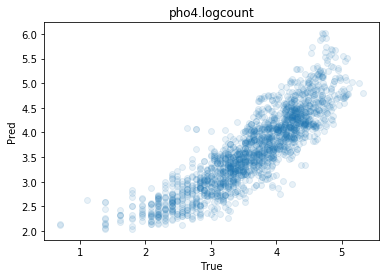

SpearmanrResult(correlation=0.8957248537287874, pvalue=0.0)


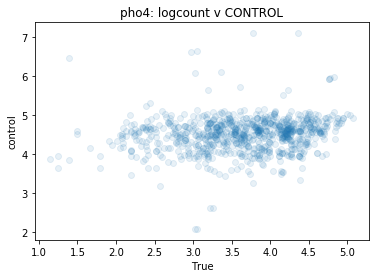

SpearmanrResult(correlation=0.18780981733320187, pvalue=2.6665073112138587e-08)


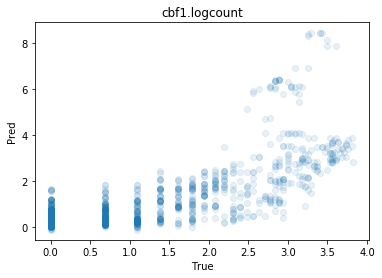

SpearmanrResult(correlation=0.6826885302501452, pvalue=1.871930089881737e-237)


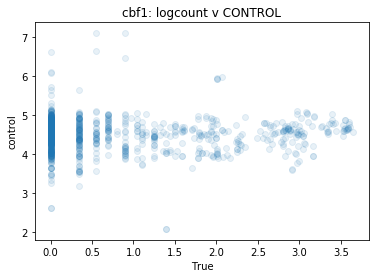

SpearmanrResult(correlation=-0.0565213486597905, pvalue=0.09685336403143009)


In [9]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.stats import spearmanr, pearsonr

def plot_scatter(xvals, yvals, xlabel, ylabel, title):
    plt.scatter(xvals, yvals, alpha=0.1)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()
    print(spearmanr(xvals,yvals))

taskToCorrelation = {}
taskToInpCorrelation = {}
for task in task_names:
    plot_scatter(xvals=test_targets[task+".logcount"].ravel(),
                 yvals=test_preds[task+".logcount"].ravel(),
                 xlabel="True", ylabel="Pred", title=task+".logcount")
    plot_scatter(xvals=np.mean(test_targets[task+".logcount"],axis=-1),
                 yvals=test_inputs['control_logcount'],
                 xlabel="True", ylabel="control", title=task+": logcount v CONTROL")
    taskToCorrelation[task] = spearmanr(test_targets[task+".logcount"].ravel(),
                                        test_preds[task+".logcount"].ravel())
    taskToInpCorrelation[task] = spearmanr(np.mean(test_targets[task+".logcount"],axis=-1),
                                        test_inputs['control_logcount'])

102
pho4: profile preds


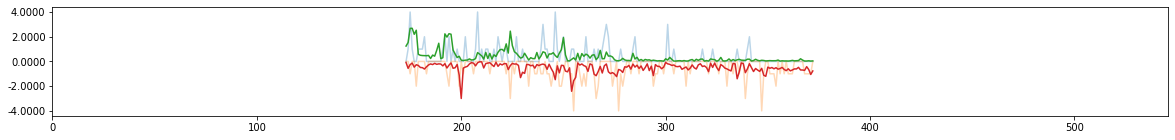

cbf1: profile preds


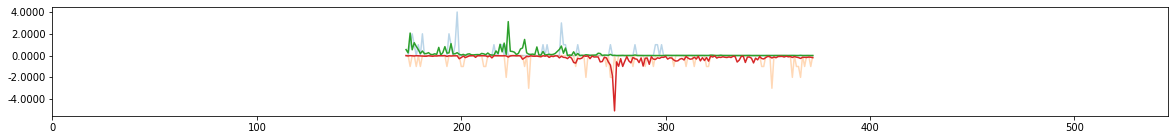

99
pho4: profile preds


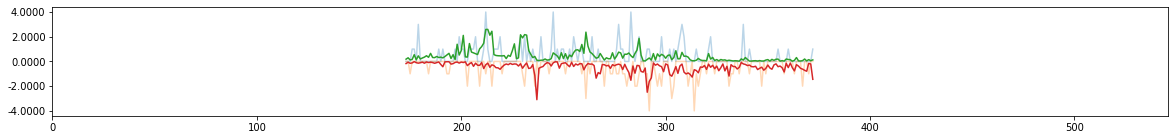

cbf1: profile preds


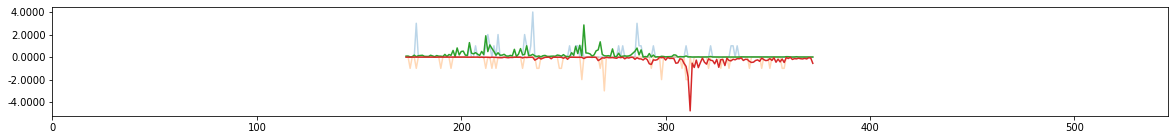

97
pho4: profile preds


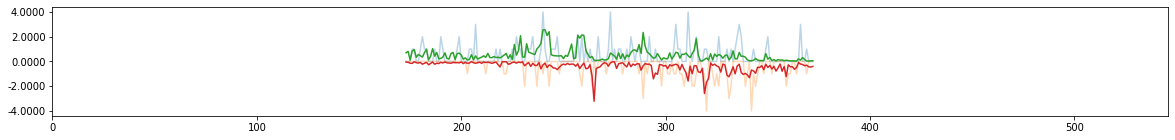

cbf1: profile preds


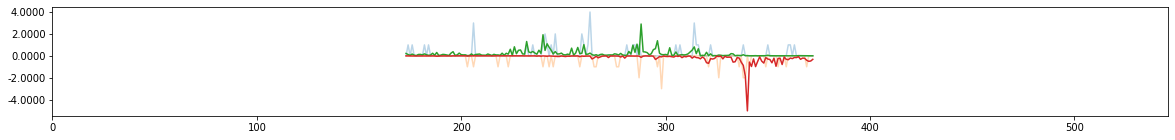

98
pho4: profile preds


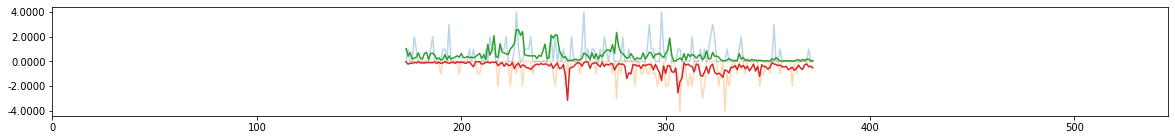

cbf1: profile preds


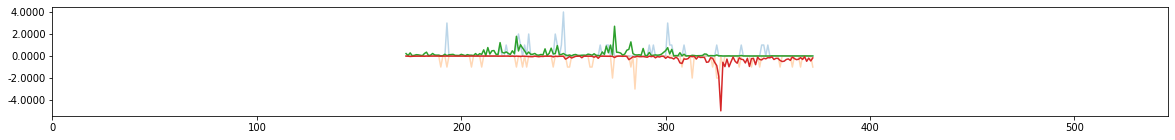

65
pho4: profile preds


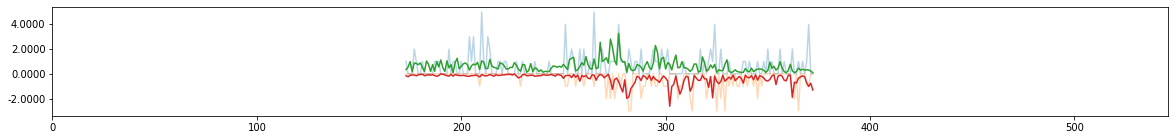

cbf1: profile preds


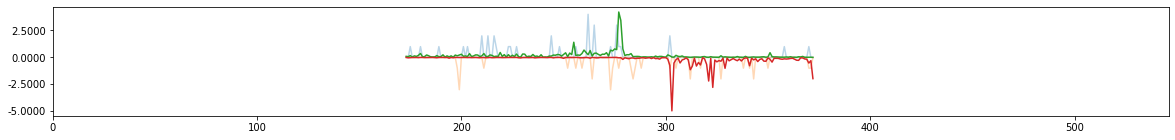

In [10]:
from matplotlib.ticker import FormatStrFormatter

#sort indices by cbf1 counts
sorted_counts = [x[0] for x in 
                       sorted(enumerate(np.sum(test_targets['cbf1.logcount'],axis=-1)),
                              key=lambda x: -x[1])]
def plot_profile(true_profile, pred_profile_logits):
    pred_profile = (np.sum(true_profile, axis=0)[None,:] #total counts
                  *(np.exp(pred_profile_logits)/
                    np.sum(np.exp(pred_profile_logits),axis=0)[None,:]) )
    plt.figure(figsize=(20,2))     
    total_flanking = seq_len - out_pred_len
    left_flank = int(0.5*total_flanking)
    right_flank = total_flanking - left_flank
    plt.plot(np.arange(out_pred_len)+left_flank, true_profile[:,0], alpha=0.3)
    if (true_profile.shape[1] == 2):
        plt.plot(np.arange(out_pred_len)+left_flank, -true_profile[:,1], alpha=0.3)
    plt.plot(np.arange(out_pred_len)+left_flank, pred_profile[:,0])
    if (true_profile.shape[1] == 2):
        plt.plot(np.arange(out_pred_len)+left_flank, -pred_profile[:,1])
    plt.xlim(0,seq_len)
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
    plt.show()

for idx in sorted_counts[:5]:
    print(idx)
    for task in task_names:
        print(task+": profile preds")
        plot_profile(true_profile=test_targets[task+'.profile'][idx],
                         pred_profile_logits=test_preds[task+'.profile'][idx])